# Similarity Modeling 1/2: Recognizing Pigs with Deep Learning

## Student
Gallus Huber (51905700)

## Timesheet
2022-11-24 16:00 - 17:30 Setup

## Required libraries and installs

In [76]:
!cat requirements-dl-video.txt
#!pip install -r requirements-dl-video.txt

pandas
numpy
opencv-python
matplotlib

## Imports

In [77]:
import os

import numpy as np
import pandas as pd
import cv2 as cv

from matplotlib import pyplot as plt

## Constants

In [78]:
DATA_PATH = "../data/"
GROUND_TRUTH_PATH = os.path.join(DATA_PATH, "sim12-ground-truth-muppets")
VIDEO_PATH = os.path.join(DATA_PATH, "video")

# 1. Data Preparation

## 1.1 Load ground truth

In [79]:
gt = []
for file_name in os.listdir(GROUND_TRUTH_PATH):
    if file_name.endswith(".csv"):
        csv = pd.read_csv(os.path.join(GROUND_TRUTH_PATH, file_name), sep=";")
        gt.append(csv)
gt[0].head()

,Video,Frame_number,Kermit,Pigs,Audio_Pigs,Cook,Audio_Cook,StatlerWaldorf,Audio_StatlerWaldorf,Audio_MissPiggy
0,343,0,0,0,0,0,0,0,0,0
1,343,1,0,0,0,0,0,0,0,0
2,343,2,0,0,0,0,0,0,0,0
3,343,3,0,0,0,0,0,0,0,0
4,343,4,0,0,0,0,0,0,0,0


## 1.2 Load video data

In [80]:
videos = []

for file_name in os.listdir(VIDEO_PATH):
    if file_name.endswith(".avi"):
        video_capture = cv.VideoCapture(os.path.join(VIDEO_PATH, file_name))
        fps = video_capture.get(cv.CAP_PROP_FPS)
        videos.append(video_capture)
        print(f"Loaded video {file_name} with {fps} frames per second")

Loaded video Muppets-02-01-01.avi with 25.0 frames per second
Loaded video Muppets-03-04-03.avi with 25.0 frames per second
Loaded video Muppets-02-04-04.avi with 25.0 frames per second


In [81]:
FPS = 25

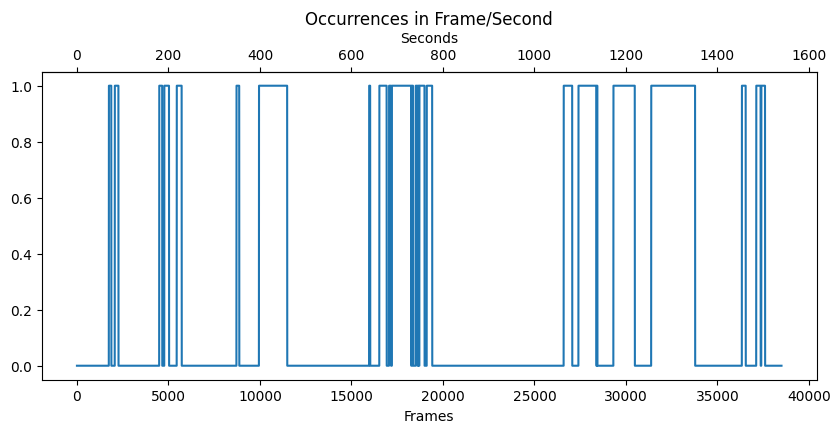

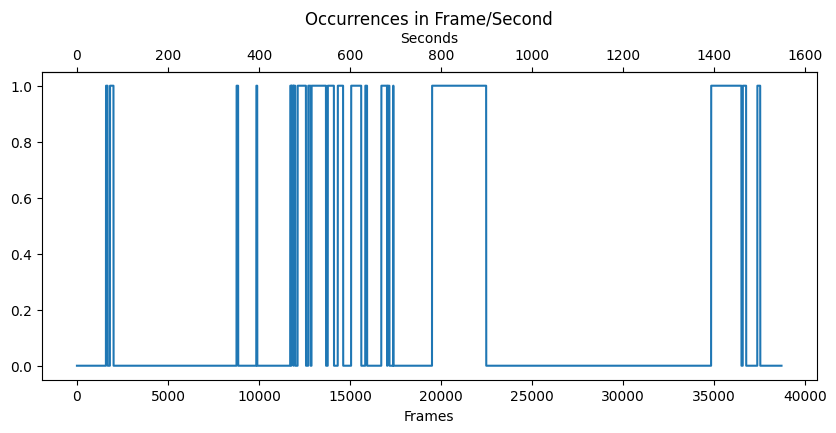

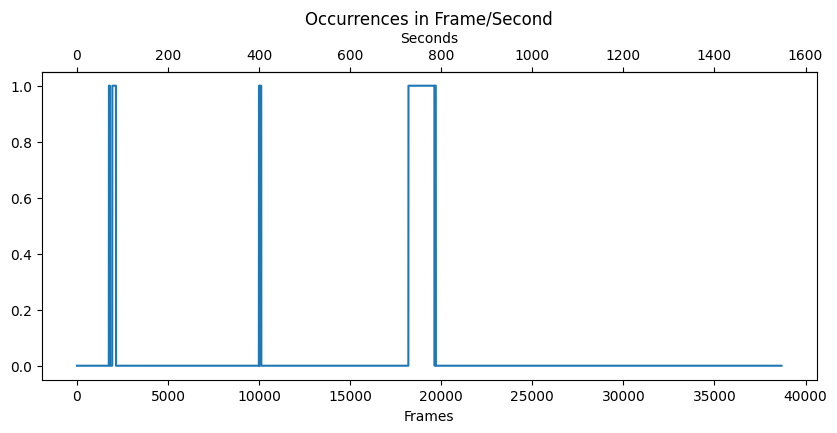

In [82]:
def plot_gt(gt, column, fps=25):
    plot = plt.figure(figsize=(10, 4))

    # define subplot
    subplot = plot.add_subplot(111)
    subplot.set_title(f"Occurrences in Frames/Seconds")

    # define x and secondary x axis
    subplot.set_xlabel('Frames')
    snd_x_axis = subplot.secondary_xaxis('top', functions=(frames_to_sec, sec_to_frames))
    snd_x_axis.set_xlabel('Seconds')

    # mark occurences
    frame_indicator = np.zeros(len(gt['Frame_number']))
    frame_indicator[gt[gt[column] == 1].index] = 1

    subplot.plot(gt[column].index, frame_indicator)
    plt.show()

def frames_to_sec(x):
    return x / fps

def sec_to_frames(x):
    return x * fps

plot_gt(gt[0], "Pigs", FPS)
plot_gt(gt[1], "Pigs", FPS)
plot_gt(gt[2], "Pigs", FPS)